In [1]:
import itertools
import jax.numpy as np
import matplotlib.pyplot as plt

from functools import partial
from jax import grad, jit, random, vmap
from jax.example_libraries import optimizers
from jax.flatten_util import ravel_pytree
from jax.nn import relu
from torch.utils import data
from tqdm import trange

## Utils

In [2]:
class dotdict(dict):
    """dot.notation access to dictionary attributes."""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


@partial(jit, static_argnums=(0,))
def runge_kutta(f, x, u, h):
    """f(x, u) -> next_x."""
    k1 = f(x, u)
    k2 = f(x + 0.5 * h * k1, u)
    k3 = f(x + 0.5 * h * k2, u)
    k4 = f(x + h * k3, u)
    next_x = x + (k1 + 2 * k2 + 2 * k3 + k4) * h / 6
    return next_x

def integrate(method, f, control, x0, h, N):
    soln = dotdict()
    soln.x = []
    soln.t = []
    soln.u = []

    x = x0

    t = 0 * h
    u = control(t, x)
    soln.x.append(x)


    for n in range(1, N):
        # log previous control
        soln.t.append(t)
        soln.u.append(u)
        # compute next state
        x_next = runge_kutta(f, x, u, h)
        # log next state
        soln.x.append(x_next)
        x = x_next
        t = n * h
        u = control(t, x)

    soln.x = np.vstack(soln.x)
    soln.t = np.vstack(soln.t)
    soln.u = np.vstack(soln.u)

    return soln

def integrate_deeponet(model, best_params, control, x0, h, N):
    P_test = 2
    y_star = np.linspace(0, h, P_test).reshape(-1, 1)
    soln = dotdict()
    soln.x = []
    soln.t = []
    soln.u = []

    x = np.array(x0)
    t = 0 * h
    u = control(t, x)
    soln.x.append(x)

    for n in range(1, N):
        # log previous control
        soln.t.append(t)
        soln.u.append(u)
        u_test = np.hstack([x, u])
        u_star = np.tile(u_test, (P_test, 1))
        theta_predk, theta_dot_predk = model.predict(best_params, u_star, y_star)
        # collect next state
        x = np.hstack([theta_predk[-1], theta_dot_predk[-1]])
        # log next state
        soln.x.append(x)
        t = n * h
        u = control(t, x)

    soln.x = np.vstack(soln.x)
    soln.t = np.vstack(soln.t)
    soln.u = np.vstack(soln.u)

    return soln

def L2_relative_error(y_true, y_pred):
    return 100 * np.linalg.norm(y_true - y_pred) / np.linalg.norm(y_true)

!sudo apt-get -y install dvipng texlive-latex-extra texlive-fonts-recommended cm-super

def plot_comparison(x_list, y_list, legend_list, xlim=None, ylim=None, xlabel="time (s)", ylabel="machine angle", figsize=(12,8), color_list=None, linestyle_list=None, fig_path=None):
    plt.rcParams['font.size'] = '30'
    plt.rcParams['text.usetex'] = True
    fig = plt.figure(figsize=figsize)
    for x_i, y_i, legend_i, c_i, ls_i in zip(x_list, y_list, legend_list, color_list, linestyle_list):
        plt.plot(x_i.reshape(-1,), y_i.reshape(-1,), lw=4.0, color=c_i, linestyle=ls_i, label=legend_i)
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # plt.tight_layout()
    plt.legend(loc="best", fontsize=24)
    if fig_path is not None:
        plt.savefig(fig_path)
    else:
        plt.show()




texlive-fonts-recommended is already the newest version (2019.20200218-1).
texlive-fonts-recommended set to manually installed.
The following additional packages will be installed:
  cm-super-minimal fonts-droid-fallback fonts-lato fonts-noto-mono
  fonts-urw-base35 ghostscript javascript-common libapache-pom-java
  libcommons-logging-java libcommons-parent-java libfontbox-java libgs9
  libgs9-common libidn11 libijs-0.35 libjbig2dec0 libjs-jquery libpdfbox-java
  libruby2.7 libxtst6 libxxf86dga1 pfb2t1c2pfb poppler-data
  preview-latex-style rake ruby ruby-minitest ruby-net-telnet
  ruby-power-assert ruby-test-unit ruby-xmlrpc ruby2.7 rubygems-integration
  tcl tcl8.6 texlive-pictures texlive-plain-generic tk tk8.6 x11-utils
  xbitmaps xterm
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre
  ghostscript-x apache2 | lighttpd | httpd libavalon-framework-java
  libcommons-logging-java-doc libexcalibur-logkit-java liblog4j1.2-java
  poppler-utils fo

In [3]:
# define the pendulu's vector field
m = 1
l = 1
I = (1 / 12) * m * (l ** 2)
b = 0.01
g = 9.81
def pendulum(x, u):
    theta, omega = x
    f_theta = omega
    f_omega = (1 / (0.25 * m * (l ** 2) + I)) * (u - b * omega - 0.5 * m * l * g * np.sin(theta))
    return np.array([f_theta, f_omega])

## Data

In [4]:
class DataGenerator(data.Dataset):
    def __init__(self, u, y, s, 
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u
        self.y = y
        self.s = s
        
        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=True)
        s = self.s[idx,:]
        y = self.y[idx,:]
        u = self.u[idx,:]
        # Construct batch
        inputs = (u, y)
        outputs = s
        return inputs, outputs

In [5]:
def generate_one_training_data(key, m=1):
    key_u, key_y = random.split(key)
    
    u_min = np.array([-np.pi, -8.0,-2.0]).flatten()
    u_max = np.array([np.pi, 8.0, 2.0]).flatten()
    
    u_train = random.uniform(key_u, shape=(m,3), minval=u_min, maxval=u_max)
    y_train = random.uniform(key_y, shape=(1,), minval=0.0, maxval=0.1)
    state = u_train.flatten()[0:2]
    s_train = runge_kutta(pendulum, u_train.flatten()[0:2], u_train.flatten()[-1], y_train)

    return u_train, y_train, s_train

# Generate training data corresponding to N input sample
def generate_training_data(key, N, m):
    keys = random.split(key, N)
    gen_fn = jit(lambda key: generate_one_training_data(key, m=1))
    u_train, y_train, s_train = vmap(gen_fn)(keys)

    u_train = np.float32(u_train.reshape(N,-1))
    y_train = np.float32(y_train.reshape(N,-1))
    s_train = np.float32(s_train.reshape(N,-1))

    return u_train, y_train, s_train

## Models

In [6]:
def MLP(layers, activation=relu):
    """vanilla MLP"""
    def init(rng_key):
        def init_layer(key, d_in, d_out):
            k1, k2 = random.split(key)
            glorot_stddev = 1.0 / np.sqrt((d_in + d_out) / 2.0)
            W = glorot_stddev * random.normal(k1, (d_in, d_out))
            b = np.zeros(d_out)
            return W, b
        key, *keys = random.split(rng_key, len(layers))
        params = list(map(init_layer, keys, layers[:-1], layers[1:]))
        return params
    def apply(params, inputs):
        for W, b in params[:-1]:
            outputs = np.dot(inputs, W) + b
            inputs = activation(outputs)
        W, b = params[-1]
        outputs = np.dot(inputs, W) + b
        return outputs
    return init, apply

def FF_MLP(layers, freqs, activation=relu):
    """Fourier feature net"""
    def input_encoding(x, w):
        out = np.hstack([np.sin(np.dot(x, w)), np.cos(np.dot(x, w))])
        return out
    FF = freqs * random.normal(random.PRNGKey(0),(layers[0], layers[1]//2))
    def init(rng_key):
        def init_layer(key, d_in, d_out):
            k1, k2 = random.split(key)
            glorot_stddev = 1.0 / np.sqrt((d_in + d_out) / 2.0)
            W = glorot_stddev * random.normal(k1, (d_in, d_out))
            b = np.zeros(d_out)
            return W, b
        key, *keys = random.split(rng_key, len(layers))
        params = list(map(init_layer, keys, layers[1:-1], layers[2:]))
        return params
    def apply(params, inputs):
        H = input_encoding(inputs, FF)
        for W, b in params[:-1]:
            outputs = np.dot(H, W) + b
            H = activation(outputs)
        W, b = params[-1]
        outputs = np.dot(H, W) + b
        return outputs
    return init, apply

def modified_MLP(layers, activation=relu):
    """Modified MLP"""
    def xavier_init(key, d_in, d_out):
        glorot_stddev = 1.0 / np.sqrt((d_in + d_out) / 2.0)
        W = glorot_stddev * random.normal(key, (d_in, d_out))
        b = np.zeros(d_out)
        return W, b
    def init(rng_key):
        U1, b1 = xavier_init(random.PRNGKey(12345), layers[0], layers[1])
        U2, b2 = xavier_init(random.PRNGKey(54321), layers[0], layers[1])
        def init_layer(key, d_in, d_out):
            k1, k2 = random.split(key)
            W, b = xavier_init(k1, d_in, d_out)
            return W, b
        key, *keys = random.split(rng_key, len(layers))
        params = list(map(init_layer, keys, layers[:-1], layers[1:]))
        return (params, U1, b1, U2, b2)
    def apply(params, inputs):
        params, U1, b1, U2, b2 = params
        U = activation(np.dot(inputs, U1) + b1)
        V = activation(np.dot(inputs, U2) + b2)
        for W, b in params[:-1]:
            outputs = activation(np.dot(inputs, W) + b)
            inputs = np.multiply(outputs, U) + np.multiply(1 - outputs, V)
        W, b = params[-1]
        outputs = np.dot(inputs, W) + b
        return outputs
    return init, apply

In [7]:
# DeepONet
class DeepONet:
    def __init__(self, branch, trunk):
        # Branch
        if branch.type == "MLP":
            self.branch_init, self.branch_apply = MLP(branch.layers, activation=branch.activation)
        elif branch.type == "FF":
            self.branch_init, self.branch_apply = FF_MLP(branch.layers, 2, activation=branch.activation)
        elif branch.type == "modified":
            self.branch_init, self.branch_apply = modified_MLP(branch.layers, activation=branch.activation)

        # Trunk
        if trunk.type == "MLP":
            self.trunk_init, self.trunk_apply = MLP(trunk.layers, activation=trunk.activation)
        elif trunk.type == "FF":
            self.trunk_init, self.trunk_apply = FF_MLP(trunk.layers, 2, activation=trunk.activation)
        elif trunk.type == "modified":
            self.trunk_init, self.trunk_apply = modified_MLP(trunk.layers, activation=trunk.activation)

        # initialize
        branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
        trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
        params = (branch_params, trunk_params)

        # use optimizers to set optimizer initialization and update functions
        self.opt_init, self.opt_update, self.get_params = optimizers.adam(
            (optimizers.exponential_decay(1e-3, decay_steps=2000, decay_rate=0.9))
        )
        self.opt_state = self.opt_init(params)
        self.itercount = itertools.count()

        # loggers
        self.loss_log = []
        
        self.dim_state = 2    # the two-axis is a fourth-order model
        self.best_loss = 1e10

    # Define DeepONet architecture
    def operator_net(self, params, u, y):
        branch_params, trunk_params = params
        B = self.branch_apply(branch_params, u)
        T = self.trunk_apply(trunk_params, y)
        
        p = int(B.shape[0] / self.dim_state)
        B1 = B[:p]
        B2 = B[p:2*p]
        
        T1 = T[:p]
        T2 = T[p:2*p]
        
        x1 = np.sum(B1 * T1)
        x2 = np.sum(B2 * T2)
        
        return x1, x2

    def supervised_loss(self, params, batch):
        inputs, outputs = batch
        u, y = inputs
        x1 = outputs[:, 0:1]
        x2 = outputs[:, 1:2]
        
        # compute forward pass
        x1_pred, x2_pred = vmap(self.operator_net, (None, 0, 0))(params, u, y)

        # compute loss
        loss_1 = np.mean((x1.flatten() - x1_pred) ** 2)
        loss_2 = np.mean((x2.flatten() - x2_pred) ** 2)
        
        loss = loss_1 + loss_2

        return 1 * loss

    def loss(self, params, res_batch):
        loss_res = self.supervised_loss(params, res_batch)
        loss = loss_res
        return loss

    # Define a compiled update state
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, res_batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, res_batch)
        return self.opt_update(i, g, opt_state)


    # Optimize parameters in a loop
    def train(self, res_dataset, nIter=1000):
        # define the data iterator
        res_data = iter(res_dataset)
        
        pbar = trange(nIter)
        # main training loop
        for it in pbar:
            res_batch = next(res_data)
            
            self.opt_state = self.step(next(self.itercount), self.opt_state, res_batch)

            if it % 10 == 0:
                params = self.get_params(self.opt_state)
                
                # compute losses
                loss_val = self.loss(params, res_batch)
                
                # log losses
                self.loss_log.append(loss_val)
                
            if loss_val < self.best_loss:
                self.best_loss = loss_val
                flat_params, _  = ravel_pytree(self.get_params(self.opt_state))
                np.save('best_params.npy', flat_params)
                
            # print losses during training
            pbar.set_postfix({
                'Loss':loss_val,
                'Best-Loss':self.best_loss,
            })

    # Evaluates predictions at test points
    @partial(jit, static_argnums=(0,))
    def predict(self, params, U_star, Y_star):
        x1, x2 = vmap(self.operator_net, (None, 0, 0))(params, U_star, Y_star)
        return x1, x2

## Training

In [8]:
# Training data 
N_train = 50000
m = 1 # number of input sensors
key_train = random.PRNGKey(0) # use different key for generating training data 
u_train, y_train, s_train = generate_training_data(key_train, N_train, m)

verbose = True

if verbose:
    print("Shape for training: u_train={}, y_train={}, s_train={}".format(u_train.shape, y_train.shape, s_train.shape))

Shape for training: u_train=(50000, 3), y_train=(50000, 1), s_train=(50000, 2)


In [9]:
# Initialize model
branch = dotdict()
trunk = dotdict()
branch.type = "modified"
trunk.type = "modified"
depth = 6
branch.layers = [3] + [100] * depth + [200]
trunk.layers =  [1] + [100] * depth + [200]
branch.activation = np.sin
trunk.activation = np.sin
model = DeepONet(branch, trunk)

# Create data set
batch_size = 100
res_dataset = DataGenerator(u_train, y_train, s_train, batch_size)

model.train(res_dataset, nIter=100000)

100%|██████████| 100000/100000 [32:31<00:00, 51.24it/s, Loss=7.2752795e-07, Best-Loss=3.7447654e-07]


## Testing

### Stable response

In [10]:
# for testing, we solve the following:
T = 10
h = 0.1
N = int(T/h)
x = np.array([0.1,1.0])

@jit
def control(t, x):
    theta, theta_dot = x
    #return np.sin(t/2)         # oscillatory response
    #return t/100
    return -0.80 * theta_dot    # stable response

soln = integrate(runge_kutta, pendulum, control, x, h, N)

In [11]:
# Restore best PINN-DeepONet
flat_params = np.load('best_params.npy')
_, unravel = ravel_pytree(model.get_params(model.opt_state))
best_params = unravel(flat_params)

soln_deeponet = integrate_deeponet(model, best_params, control, x, h, N)

In [12]:
if verbose:
    print("deeponet results shapes = {}, {}, {}".format(soln_deeponet.x.shape, soln_deeponet.u.shape, soln_deeponet.t.shape))

deeponet results shapes = (100, 2), (99, 1), (99, 1)


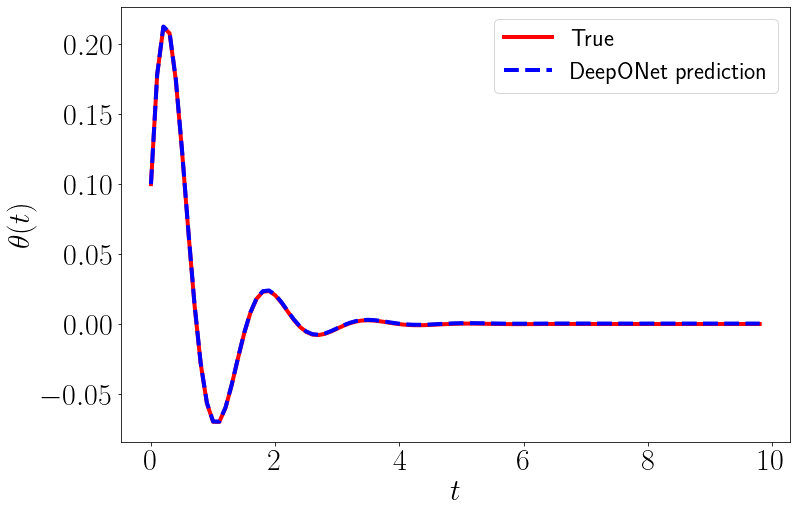

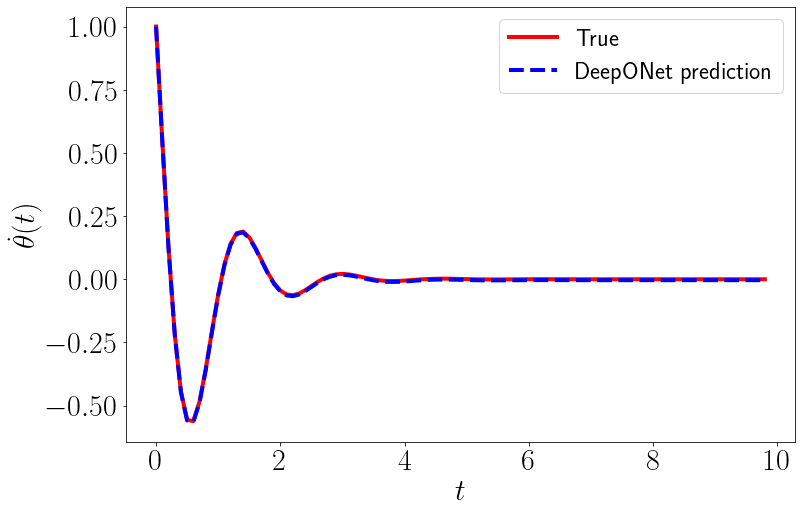

In [13]:
plot_comparison([soln.t, soln.t], [soln.x[0:-1,0].flatten(), soln_deeponet.x[0:-1,0].flatten()], legend_list=["True", "DeepONet prediction"], ylabel=r"$\theta(t)$", color_list=["red", "blue"], linestyle_list=['solid', 'dashed'], fig_path="theta.pdf", xlabel=r"$t$")
plot_comparison([soln.t, soln.t], [soln.x[0:-1,1].flatten(), soln_deeponet.x[0:-1,1].flatten()], legend_list=["True", "DeepONet prediction"], ylabel=r"$\dot{\theta}(t)$", color_list=["red", "blue"], linestyle_list=['solid', 'dashed'], fig_path="theta_dot.pdf", xlabel=r"$t$")

In [14]:
print("theta L2 relative error={}".format(L2_relative_error(soln.x[0:-1,0].flatten(), soln_deeponet.x[0:-1,0].flatten())))
print("theta_dot L2 relative error={}".format(L2_relative_error(soln.x[0:-1,1].flatten(), soln_deeponet.x[0:-1,1].flatten())))

theta L2 relative error=0.743437647819519
theta_dot L2 relative error=2.095308780670166


### Testing multiple initial conditions

In [15]:
def test_multiple_ICS(control, model, best_params, num=100, rng_key=random.PRNGKey(0), N=100, h=0.1):
    key = rng_key
    log_L2 = dotdict()
    log_L2.theta = []
    log_L2.theta_dot = []
    
    
    for k in range(num):
        key, subkey = random.split(key)
        x0 = random.uniform(key, shape=(1,), minval=-1 * np.pi / 2, maxval= 1 * np.pi / 2).flatten()
        x0 = np.array([x0[0], 0.0])
        soln_k = integrate(runge_kutta, pendulum, control, x0, h, N)
        soln_deeponet_k = integrate_deeponet(model, best_params, control, x0, h, N)
        log_L2.theta.append(L2_relative_error(soln_k.x[0:-1,0].flatten(), soln_deeponet_k.x[0:-1,0].flatten()))
        log_L2.theta_dot.append(L2_relative_error(soln_k.x[0:-1,1].flatten(), soln_deeponet_k.x[0:-1,1].flatten()))
        
    log_L2.theta = np.stack(log_L2.theta)
    log_L2.theta_dot = np.stack(log_L2.theta_dot)
        
    return log_L2

        
        
log_L2 = test_multiple_ICS(control, model, best_params, h=h, num=100, N=N)

In [16]:
print("L2-relative-error for theta mean= {}".format(np.mean(log_L2.theta)))
print("L2-relative-error for theta std= {}".format(np.std(log_L2.theta)))
print("L2-relative-error for theta_dot mean= {}".format(np.mean(log_L2.theta_dot)))
print("L2-relative-error for theta_dot std= {}".format(np.std(log_L2.theta_dot)))

L2-relative-error for theta mean= 1.0569602251052856
L2-relative-error for theta std= 2.5097291469573975
L2-relative-error for theta_dot mean= 3.3569717407226562
L2-relative-error for theta_dot std= 8.23419189453125


### Oscillatory response

In [17]:
@jit
def control(t, x):
    theta, theta_dot = x
    return np.sin(t/2)         # oscillatory response
    
soln = integrate(runge_kutta, pendulum, control, x, h, N)

In [18]:
# Restore best PINN-DeepONet
flat_params = np.load('best_params.npy')
_, unravel = ravel_pytree(model.get_params(model.opt_state))
best_params = unravel(flat_params)

soln_deeponet = integrate_deeponet(model, best_params, control, x, h, N)

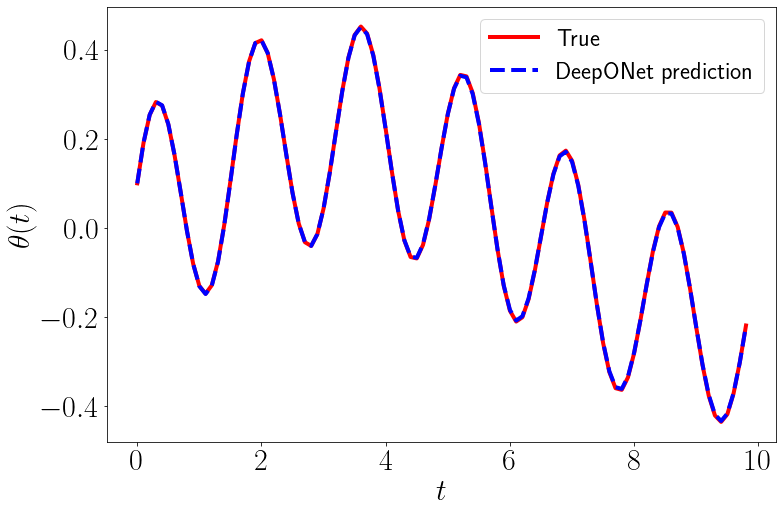

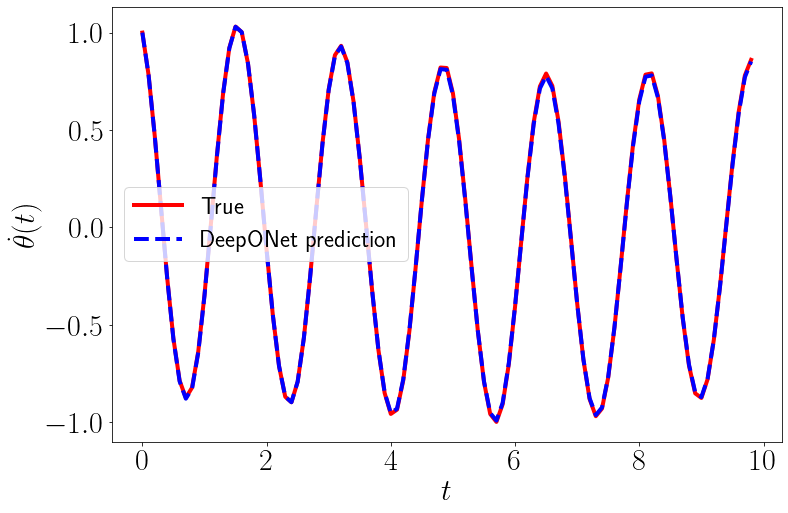

In [19]:
plot_comparison([soln.t, soln.t], [soln.x[0:-1,0].flatten(), soln_deeponet.x[0:-1,0].flatten()], legend_list=["True", "DeepONet prediction"], ylabel=r"$\theta(t)$", color_list=["red", "blue"], linestyle_list=['solid', 'dashed'], fig_path="theta_osillatory.pdf", xlabel=r"$t$")
plot_comparison([soln.t, soln.t], [soln.x[0:-1,1].flatten(), soln_deeponet.x[0:-1,1].flatten()], legend_list=["True", "DeepONet prediction"], ylabel=r"$\dot{\theta}(t)$", color_list=["red", "blue"], linestyle_list=['solid', 'dashed'], fig_path="theta_dot_oscillatory.pdf", xlabel=r"$t$")

In [20]:
print("theta L2 relative error={}".format(L2_relative_error(soln.x[0:-1,0].flatten(), soln_deeponet.x[0:-1,0].flatten())))
print("theta_dot L2 relative error={}".format(L2_relative_error(soln.x[0:-1,1].flatten(), soln_deeponet.x[0:-1,1].flatten())))

theta L2 relative error=0.5392003059387207
theta_dot L2 relative error=0.8174777030944824
